# CSYE 7105 - High Perfoamnce Machine Learning & AI - Project - Team 4 

## Analysis of Efficient Parallel Computing for Deep Learning-Based Glaucoma Detection

### This notebook focusses on preparing data - Data preprocessing Step by Step

#### 1. Import necessary libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from tqdm import tqdm
import cv2
import pandas as pd
import seaborn as sns
from IPython.display import display, Image as IPImage
from PIL import Image, ImageEnhance, ImageOps
import time

In [2]:
# For reproducibility
np.random.seed(42)
random.seed(42)

#### 2. Exploring the dataset 

In [3]:
def explore_dataset(base_dir):
    """
    Explore the dataset structure and count images in each category
    
    Args:
        base_dir (str): Base directory of the dataset
    """
    # Dataset structure: base_dir/[train, val, test]/[0, 1]
    splits = ['train', 'val', 'test']
    classes = ['0', '1']  # 0: Normal, 1: Glaucoma
    
    dataset_stats = {}
    total_images = 0
    
    print("Dataset Structure:")
    print("-" * 50)
    
    for split in splits:
        split_dir = os.path.join(base_dir, split)
        if not os.path.exists(split_dir):
            print(f"Warning: Directory {split_dir} does not exist")
            continue
        
        dataset_stats[split] = {}
        split_total = 0
        
        print(f"{split}:")
        
        for cls in classes:
            class_dir = os.path.join(split_dir, cls)
            if not os.path.exists(class_dir):
                print(f"  Warning: Directory {class_dir} does not exist")
                dataset_stats[split][cls] = 0
                continue
            
            # List all image files
            image_files = [f for f in os.listdir(class_dir) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            num_images = len(image_files)
            dataset_stats[split][cls] = num_images
            split_total += num_images
            
            # Class name for display
            class_name = "Normal" if cls == "0" else "Glaucoma"
            print(f"  {class_name} (Class {cls}): {num_images} images")
        
        print(f"  Total {split} images: {split_total}")
        total_images += split_total
    
    print("-" * 50)
    print(f"Total Dataset Size: {total_images} images")
    
    return dataset_stats

In [4]:
# Path to dataset
dataset_path = "../../project_dataset/HPC_Project"

# Explore dataset structure and count images
print("\n1. EXPLORING DATASET STRUCTURE")
stats = explore_dataset(dataset_path)


1. EXPLORING DATASET STRUCTURE
Dataset Structure:
--------------------------------------------------
train:
  Normal (Class 0): 5293 images
  Glaucoma (Class 1): 3328 images
  Total train images: 8621
val:
  Normal (Class 0): 3539 images
  Glaucoma (Class 1): 2208 images
  Total val images: 5747
test:
  Normal (Class 0): 1754 images
  Glaucoma (Class 1): 1120 images
  Total test images: 2874
--------------------------------------------------
Total Dataset Size: 17242 images


#### Checking class distributions

In [5]:
def plot_class_distribution(stats):
    """
    Plot the class distribution for each split
    
    Args:
        stats (dict): Dataset statistics from explore_dataset
    """
    splits = list(stats.keys())
    
    # Data for plotting
    normal_counts = [stats[split]['0'] for split in splits]
    glaucoma_counts = [stats[split]['1'] for split in splits]
    
    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        'Split': splits + splits,
        'Class': ['Normal']*len(splits) + ['Glaucoma']*len(splits),
        'Count': normal_counts + glaucoma_counts
    })
    
    # Create split-wise pie charts
    fig, axes = plt.subplots(1, len(splits), figsize=(15, 5))
    
    for i, split in enumerate(splits):
        # Calculate totals
        total = stats[split]['0'] + stats[split]['1']
        normal_pct = stats[split]['0'] / total * 100
        glaucoma_pct = stats[split]['1'] / total * 100
        
        # Plot pie chart
        axes[i].pie([normal_pct, glaucoma_pct], 
                   labels=['Normal', 'Glaucoma'],
                   autopct='%1.1f%%',
                   startangle=90,
                   colors=['skyblue', 'salmon'])
        axes[i].set_title(f'{split.capitalize()} Split')
    
    plt.tight_layout()
    plt.savefig('class_distribution_pie.png')
    plt.show()
    
    # Create a bar chart
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Split', y='Count', hue='Class', data=df)
    plt.title('Class Distribution Across Splits')
    plt.ylabel('Number of Images')
    plt.savefig('class_distribution_bar.png')
    plt.show()

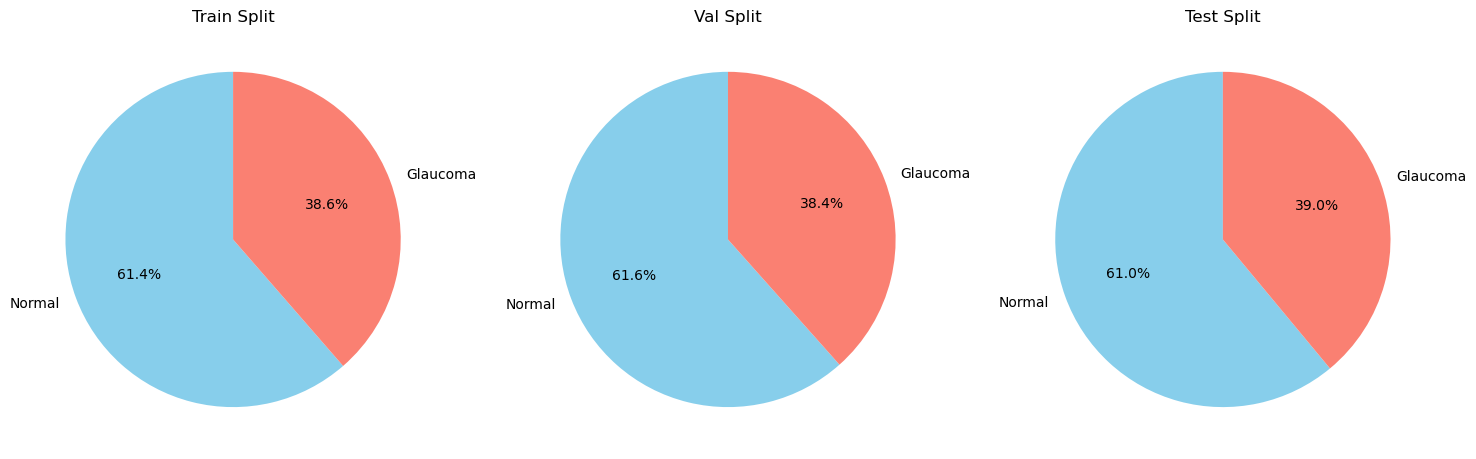

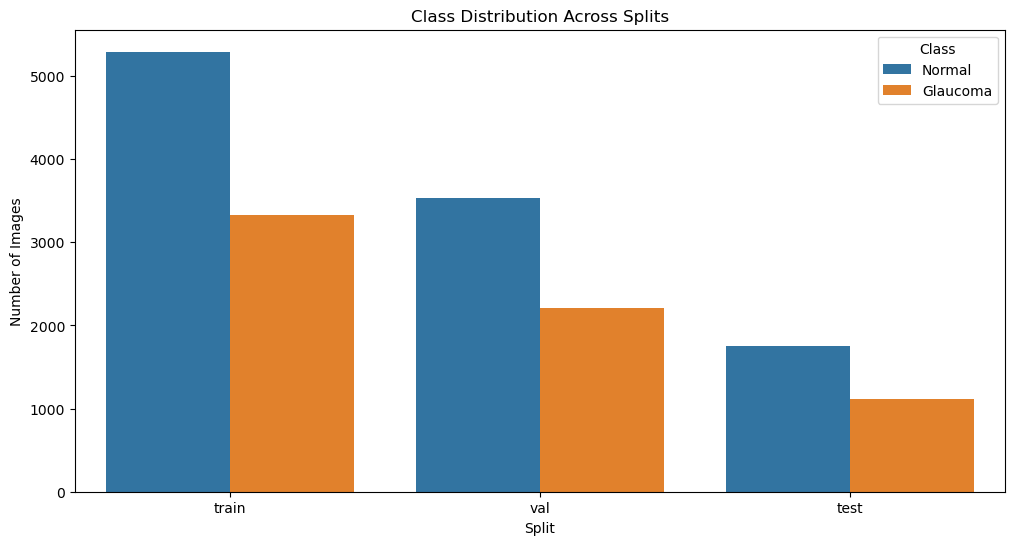

In [6]:
# Plot the class distribution
plot_class_distribution(stats)

#### Visualizing sample images

In [7]:
def visualize_sample_images(base_dir, num_samples=3):
    """
    Visualize sample images from each class in each split
    
    Args:
        base_dir (str): Base directory of the dataset
        num_samples (int): Number of samples to visualize from each class
    """
    splits = ['train', 'val', 'test']
    classes = ['0', '1']  # 0: Normal, 1: Glaucoma
    class_names = ["Normal", "Glaucoma"]
    
    fig, axes = plt.subplots(len(splits), len(classes) * num_samples, 
                            figsize=(5 * len(classes) * num_samples, 5 * len(splits)))
    
    for i, split in enumerate(splits):
        for j, cls in enumerate(classes):
            class_dir = os.path.join(base_dir, split, cls)
            if not os.path.exists(class_dir):
                continue
            
            # Get all image files
            image_files = [f for f in os.listdir(class_dir) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            # Select random samples
            if len(image_files) > 0:
                samples = random.sample(image_files, min(num_samples, len(image_files)))
                
                for k, sample in enumerate(samples):
                    img_path = os.path.join(class_dir, sample)
                    img = Image.open(img_path)
                    
                    ax_idx = j * num_samples + k
                    if len(splits) == 1:
                        axes[ax_idx].imshow(img)
                        axes[ax_idx].set_title(f"{class_names[j]}\n{img.size}")
                        axes[ax_idx].axis('off')
                    else:
                        axes[i, ax_idx].imshow(img)
                        axes[i, ax_idx].set_title(f"{split} - {class_names[j]}\n{img.size}")
                        axes[i, ax_idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_images_visualize.png')
    plt.show()

VISUALIZING SAMPLE IMAGES


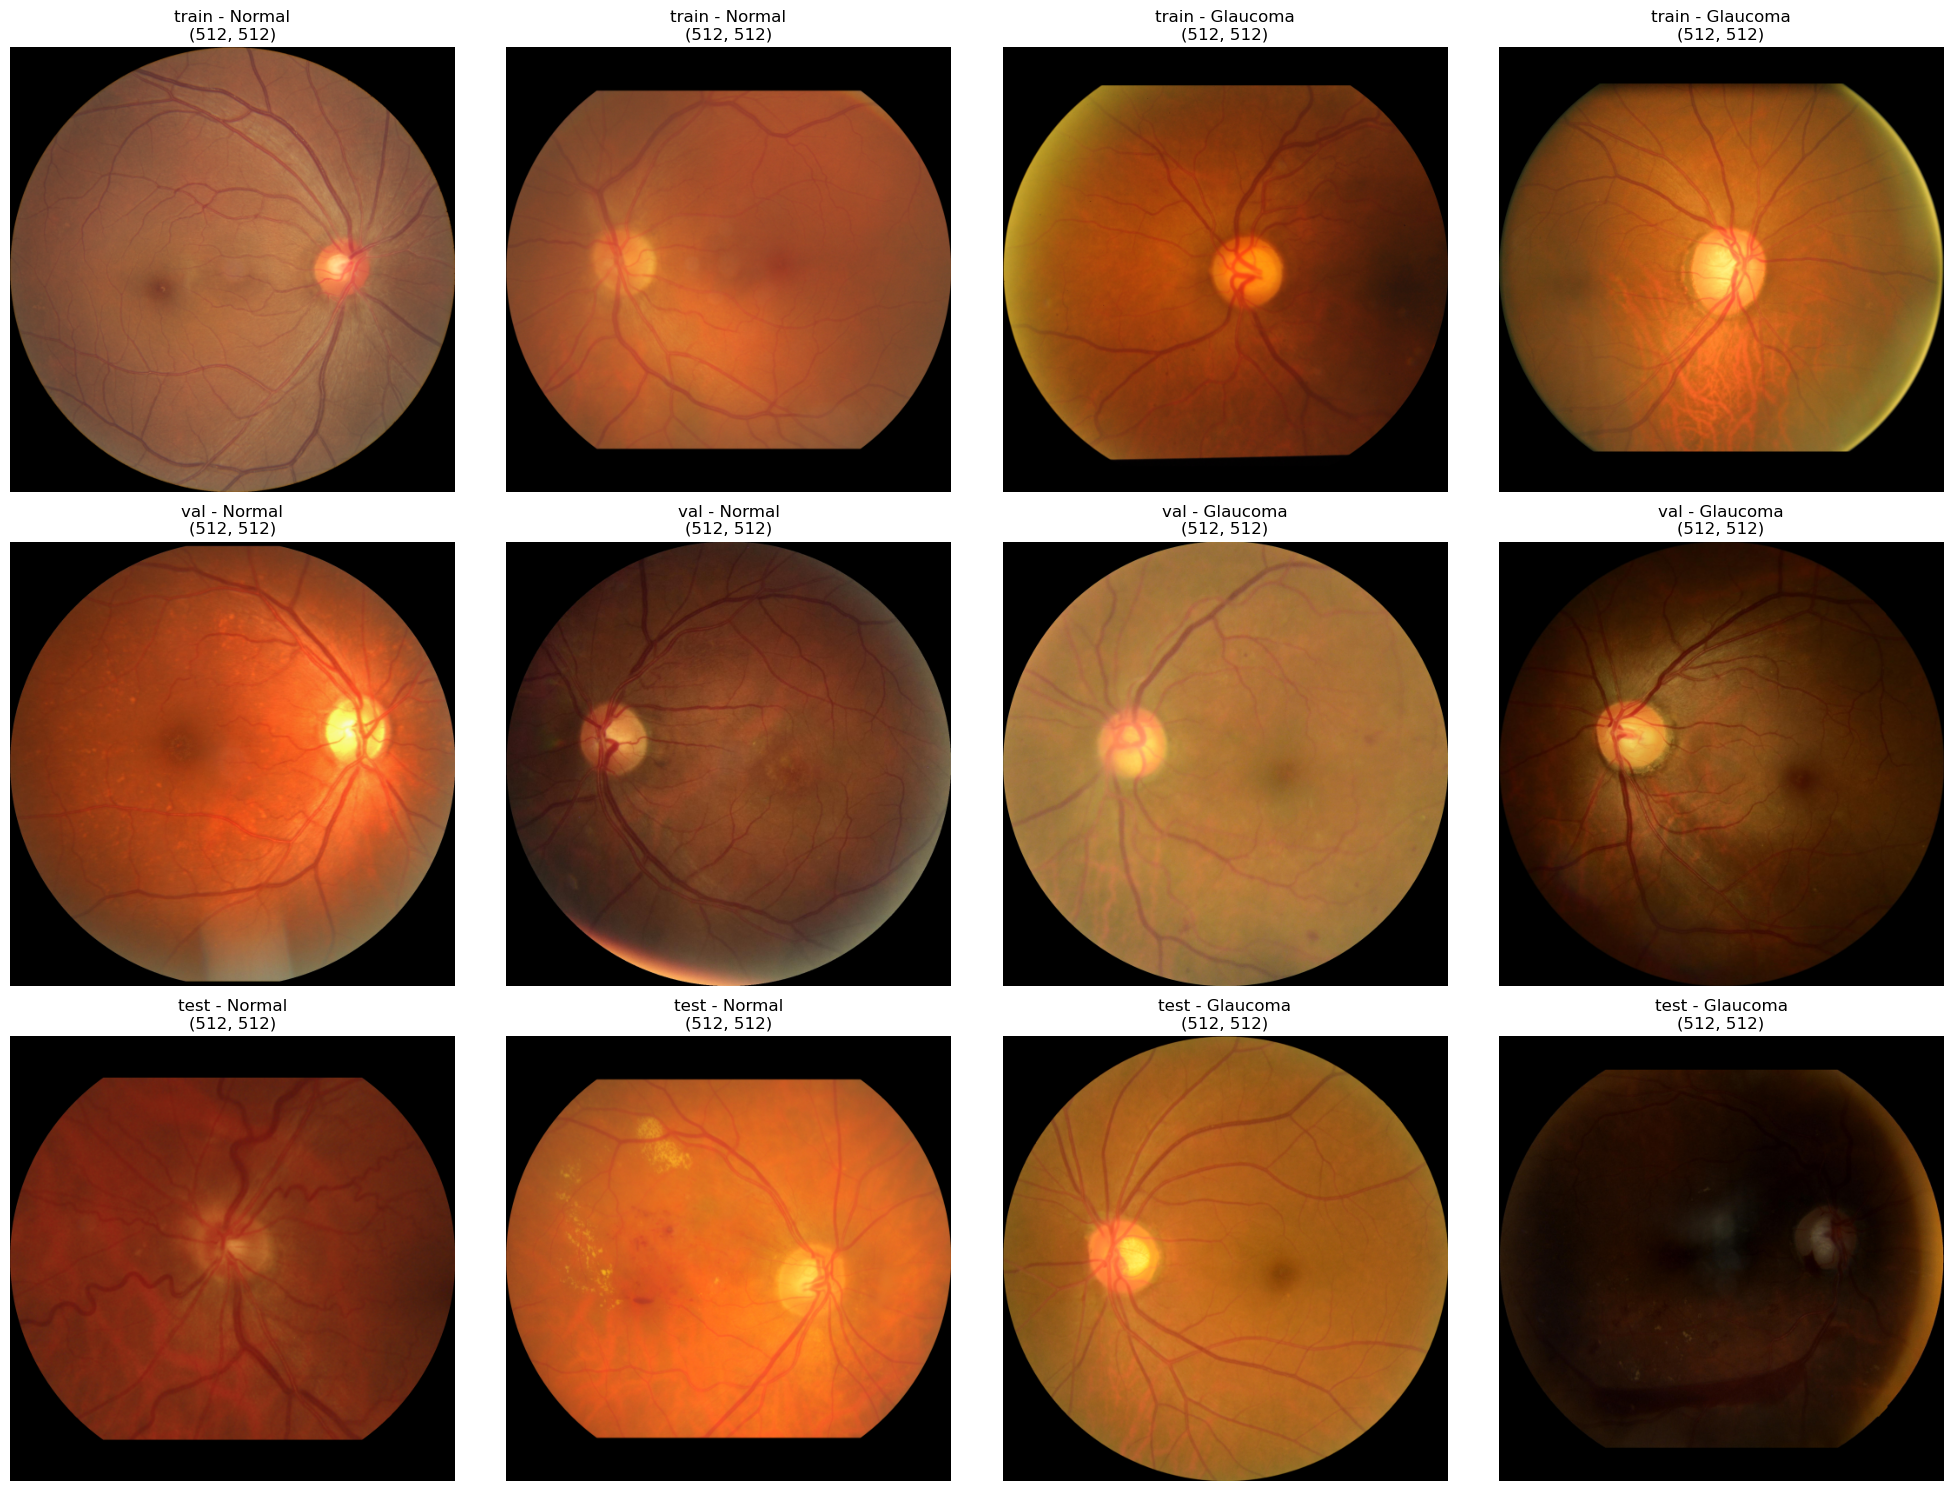

In [8]:
print("VISUALIZING SAMPLE IMAGES")
visualize_sample_images(dataset_path, num_samples=2)

#### Checking Properties of the images 

In [9]:
def analyze_image_properties(base_dir):
    """
    Analyze image properties (size, channels, etc.) across the dataset
    
    Args:
        base_dir (str): Base directory of the dataset
    """
    splits = ['train', 'val', 'test']
    classes = ['0', '1']
    
    # Initialize lists to store properties
    widths = []
    heights = []
    aspect_ratios = []
    channels = set()
    formats = set()
    
    # Limit the number of images to analyze
    max_images_per_category = 100
    
    print("Analyzing image properties...")
    
    for split in splits:
        for cls in classes:
            class_dir = os.path.join(base_dir, split, cls)
            if not os.path.exists(class_dir):
                continue
            
            image_files = [f for f in os.listdir(class_dir) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            # Sample images to analyze
            sample_files = random.sample(image_files, 
                                        min(max_images_per_category, len(image_files)))
            
            for img_file in sample_files:
                img_path = os.path.join(class_dir, img_file)
                
                try:
                    img = Image.open(img_path)
                    
                    # Record image properties
                    width, height = img.size
                    widths.append(width)
                    heights.append(height)
                    aspect_ratios.append(width / height if height > 0 else 0)
                    
                    formats.add(img.format)
                    
                    # Check number of channels
                    if img.mode == 'RGB':
                        channels.add(3)
                    elif img.mode == 'RGBA':
                        channels.add(4)
                    elif img.mode == 'L':
                        channels.add(1)
                    else:
                        channels.add(img.mode)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
    
    # Print summary statistics
    print("-" * 50)
    print("Image Properties Summary:")
    print(f"Image formats: {formats}")
    print(f"Color channels: {channels}")
    print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
    print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}")
    print(f"Aspect ratio - Min: {min(aspect_ratios):.2f}, Max: {max(aspect_ratios):.2f}, Mean: {np.mean(aspect_ratios):.2f}")
    
    # Create a dictionary for return
    properties = {
        'widths': widths,
        'heights': heights,
        'aspect_ratios': aspect_ratios,
        'formats': formats,
        'channels': channels
    }
    
    # Plot histograms
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    ax1.hist(widths, bins=20, color='skyblue', edgecolor='black')
    ax1.set_title('Image Widths')
    ax1.set_xlabel('Width (pixels)')
    ax1.set_ylabel('Count')
    
    ax2.hist(heights, bins=20, color='lightgreen', edgecolor='black')
    ax2.set_title('Image Heights')
    ax2.set_xlabel('Height (pixels)')
    
    ax3.hist(aspect_ratios, bins=20, color='salmon', edgecolor='black')
    ax3.set_title('Aspect Ratios')
    ax3.set_xlabel('Width/Height')
    
    plt.tight_layout()
    plt.savefig('image_properties.png')
    plt.show()
    
    return properties


 ANALYZING IMAGE PROPERTIES
Analyzing image properties...
--------------------------------------------------
Image Properties Summary:
Image formats: {'PNG'}
Color channels: {3}
Width - Min: 512, Max: 512, Mean: 512.0
Height - Min: 512, Max: 512, Mean: 512.0
Aspect ratio - Min: 1.00, Max: 1.00, Mean: 1.00


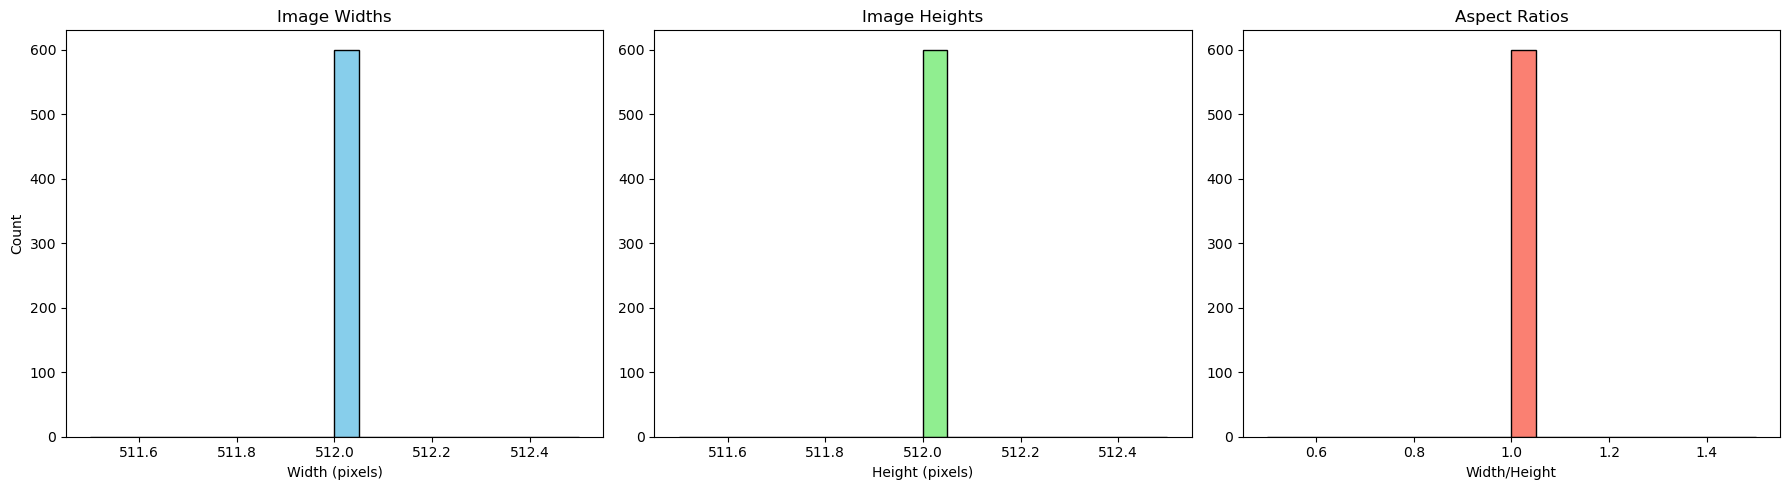

In [10]:
print("\n ANALYZING IMAGE PROPERTIES")
properties = analyze_image_properties(dataset_path)

#### Demonstrating various preprocessing steps with a sample of images

In [11]:
def preprocess_sample_images(base_dir, num_samples=2):
    """
    Preprocess sample images and display the preprocessing steps
    
    Args:
        base_dir (str): Base directory of the dataset
        num_samples (int): Number of samples from each class
    """
    # Select a few sample images
    samples = []
    splits = ['train']  # Just use training samples
    classes = ['0', '1']
    
    for split in splits:
        for cls in classes:
            class_dir = os.path.join(base_dir, split, cls)
            if not os.path.exists(class_dir):
                continue
            
            image_files = [f for f in os.listdir(class_dir) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            if image_files:
                # Get samples from each class
                class_samples = random.sample(image_files, min(num_samples, len(image_files)))
                for sample in class_samples:
                    samples.append((os.path.join(class_dir, sample), 
                                  f"{split}_{cls}_{sample}"))
    
    img_size = (224, 224)
    
    # Define preprocessing steps and show results
    for i, (img_path, img_id) in enumerate(samples):
        # Original image
        img_orig = cv2.imread(img_path)
        if img_orig is None:
            print(f"Warning: Could not read image {img_path}")
            continue
        
        img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
        
        # Step 1: Resize
        img_resized = cv2.resize(img_orig, img_size)
        
        # Step 2: Normalize
        img_normalized = img_resized / 255.0
        
        # Step 3: Apply CLAHE for contrast enhancement
        img_lab = cv2.cvtColor(img_resized, cv2.COLOR_RGB2LAB)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_lab[:,:,0] = clahe.apply(img_lab[:,:,0])
        img_clahe = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
        
        # Step 4: Gamma correction to enhance features
        gamma = 1.2
        img_gamma = np.power(img_resized / 255.0, gamma) * 255.0
        img_gamma = np.clip(img_gamma, 0, 255).astype(np.uint8)
        
        # Display preprocessing steps
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        
        axes[0].imshow(img_orig)
        axes[0].set_title("Original")
        axes[0].axis('off')
        
        axes[1].imshow(img_resized)
        axes[1].set_title(f"Resized ({img_size[0]}x{img_size[1]})")
        axes[1].axis('off')
        
        axes[2].imshow(img_normalized)
        axes[2].set_title("Normalized [0,1]")
        axes[2].axis('off')
        
        axes[3].imshow(img_clahe)
        axes[3].set_title("CLAHE (Contrast Enhanced)")
        axes[3].axis('off')
        
        axes[4].imshow(img_gamma)
        axes[4].set_title(f"Gamma Correction (γ={gamma})")
        axes[4].axis('off')
        
        plt.tight_layout()
        plt.show()


 DEMONSTRATING PREPROCESSING STEPS


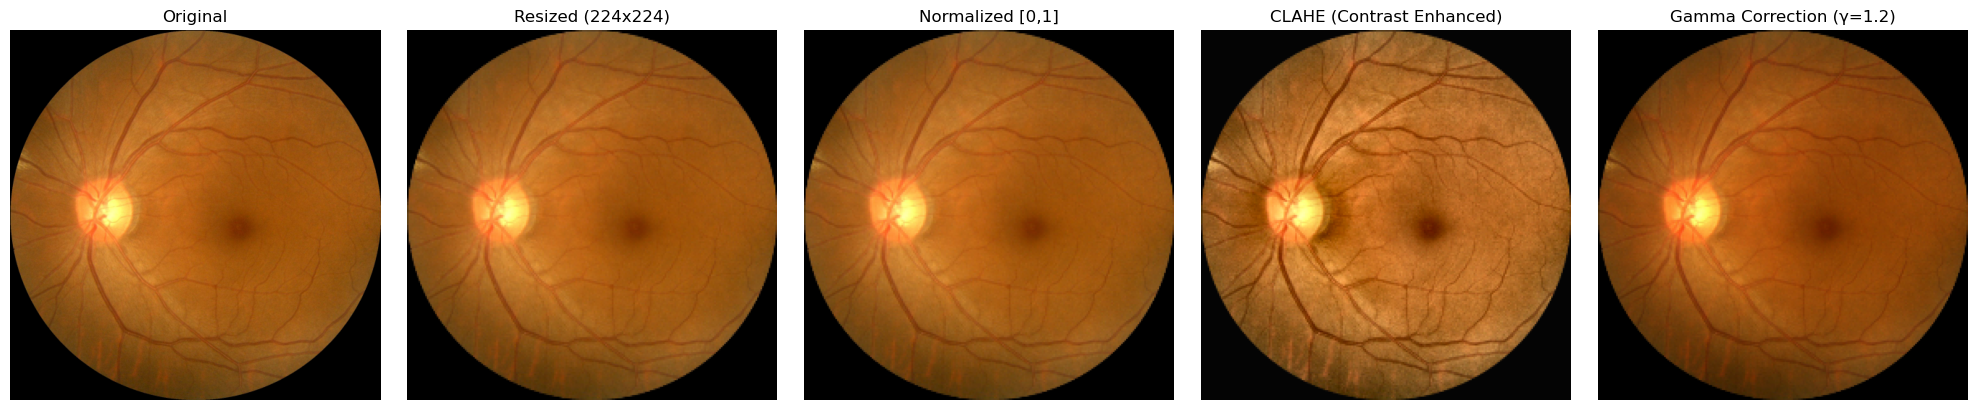

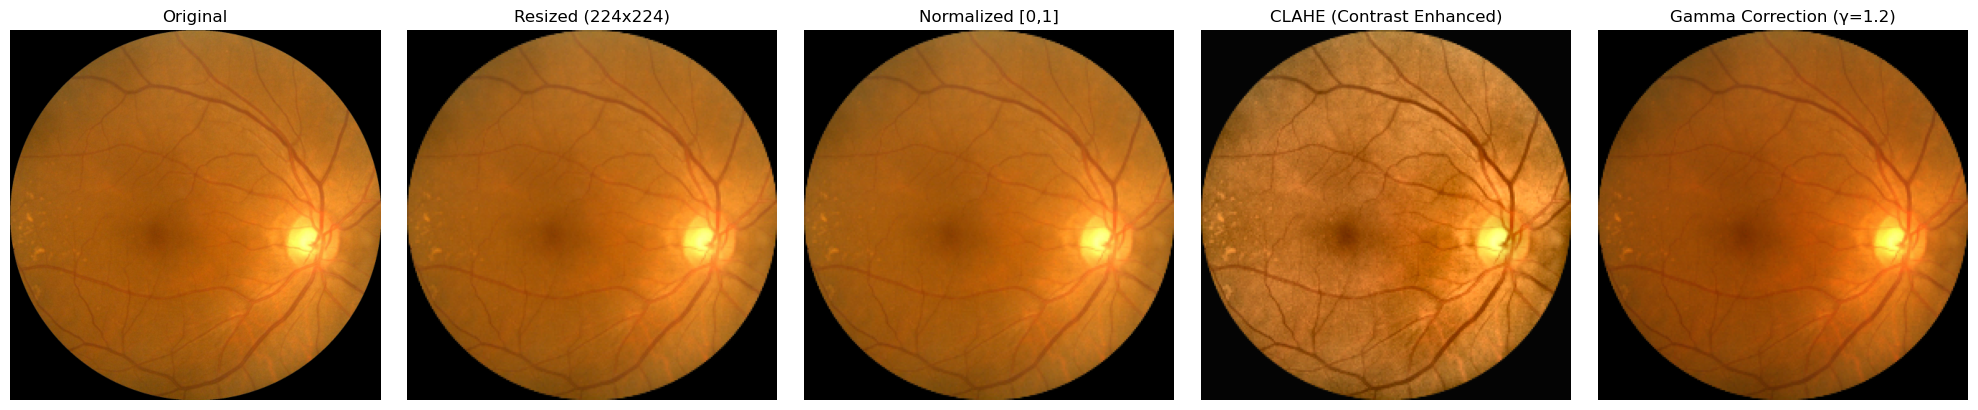

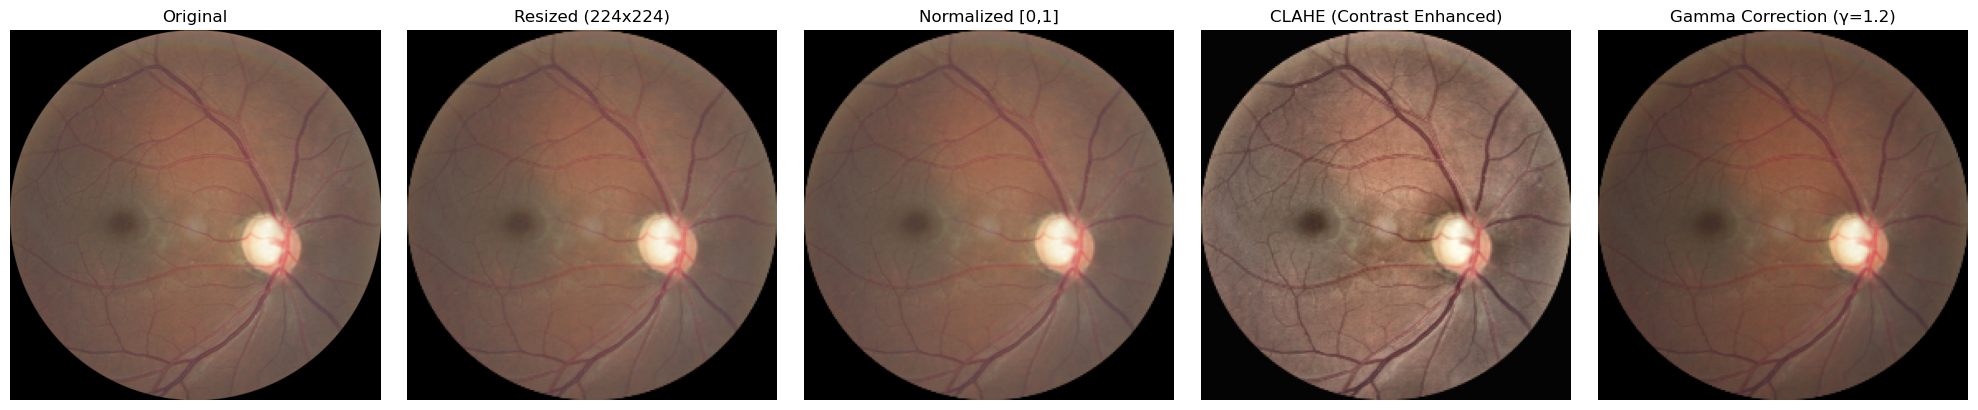

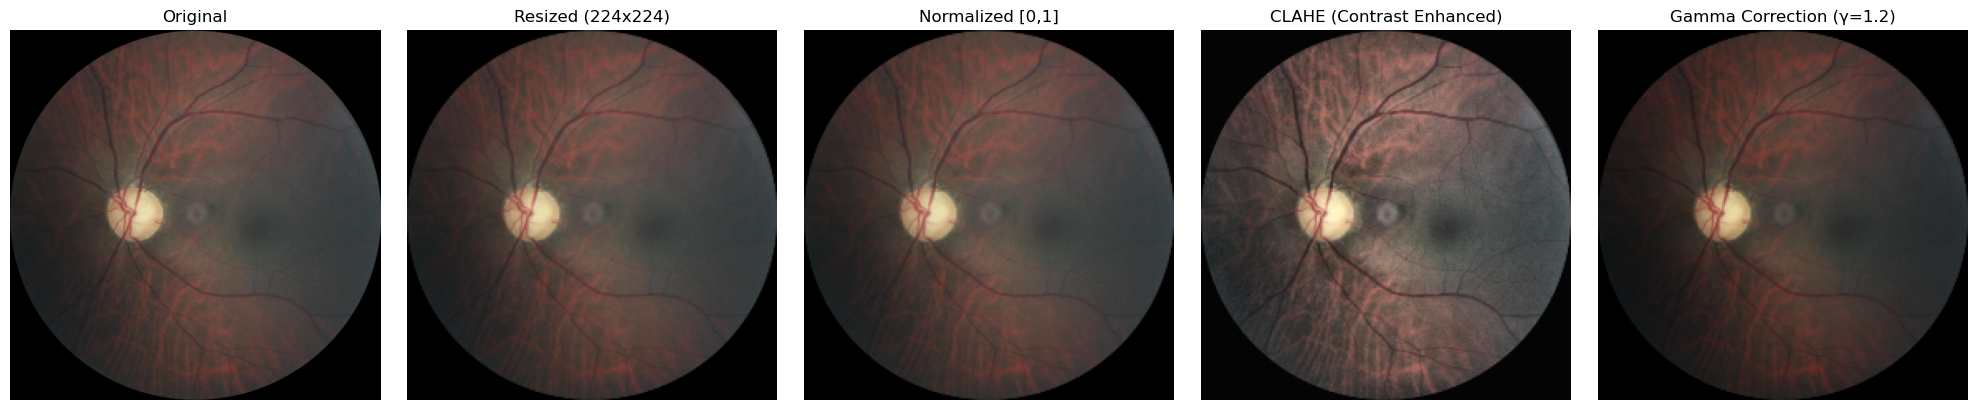

In [12]:
print("\n DEMONSTRATING PREPROCESSING STEPS")
preprocess_sample_images(dataset_path)

#### Data preprocessing

In [16]:
import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from PIL import Image, ImageEnhance, ImageOps

class GlaucomaPreprocessor:
    """
    A class to preprocess glaucoma images using advanced preprocessing techniques
    """
    def __init__(self, input_dir, output_dir, img_size=(224, 224)):
        """
        Initialize the preprocessor
        
        Args:
            input_dir (str): Directory with raw images
            output_dir (str): Directory to save preprocessed images
            img_size (tuple): Target image size
        """
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.img_size = img_size
        
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        
        # Keep track of class distribution
        self.class_counts = {'train': {0: 0, 1: 0}, 
                            'val': {0: 0, 1: 0}, 
                            'test': {0: 0, 1: 0}}
    
    def advanced_preprocessing(self, img):
        """Advanced preprocessing with multiple enhancements"""
        img_resized = cv2.resize(img, self.img_size)
        
        # Convert to LAB space
        img_lab = cv2.cvtColor(img_resized, cv2.COLOR_RGB2LAB)
        
        # Apply CLAHE for contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_lab[:,:,0] = clahe.apply(img_lab[:,:,0])
        img_enhanced = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
        
        # Apply gamma correction to enhance features
        gamma = 1.2
        img_gamma = np.power(img_enhanced / 255.0, gamma)
        
        # Apply median blur to reduce noise
        img_denoised = cv2.medianBlur((img_gamma*255).astype(np.uint8), 3) / 255.0
        
        return img_denoised
    
    def _create_augmented_images(self, img, base_filename, label, split, num_augmentations=3):
        """
        Create augmented versions of an image
        
        Args:
            img (numpy.ndarray): Input image
            base_filename (str): Base filename for saving
            label (int): Class label
            split (str): Dataset split (train/val/test)
            num_augmentations (int): Number of augmented images to create
        """
        # Convert numpy array to PIL Image for easier augmentation
        pil_img = Image.fromarray((img * 255).astype(np.uint8))
        
        augmentations = []
        
        # Define augmentation operations
        for i in range(num_augmentations):
            aug_img = pil_img.copy()
            
            # Random rotation
            if random.random() > 0.5:
                aug_img = aug_img.rotate(random.uniform(-20, 20), resample=Image.BILINEAR)
            
            # Random horizontal flip
            if random.random() > 0.5:
                aug_img = ImageOps.mirror(aug_img)
            
            # Random brightness/contrast adjustment
            if random.random() > 0.5:
                factor = random.uniform(0.8, 1.2)
                aug_img = ImageEnhance.Brightness(aug_img).enhance(factor)
            
            if random.random() > 0.5:
                factor = random.uniform(0.8, 1.2)
                aug_img = ImageEnhance.Contrast(aug_img).enhance(factor)
            
            # Random crop and resize
            if random.random() > 0.5:
                width, height = aug_img.size
                crop_size = min(width, height) * random.uniform(0.8, 0.9)
                left = random.uniform(0, width - crop_size)
                top = random.uniform(0, height - crop_size)
                aug_img = aug_img.crop((left, top, left + crop_size, top + crop_size))
                aug_img = aug_img.resize(self.img_size, Image.BILINEAR)
            
            # Convert back to numpy array
            aug_array = np.array(aug_img) / 255.0
            
            # Save augmented image
            aug_filename = f"{base_filename}_aug{i+1}.npy"
            aug_path = os.path.join(self.output_dir, split, str(label), aug_filename)
            np.save(aug_path, aug_array)
            
            augmentations.append(aug_array)
            
            # Update class counts
            self.class_counts[split][label] += 1
        
        return augmentations
    
    def preprocess_dataset(self, apply_augmentation=True):
        """
        Preprocess the entire dataset using advanced preprocessing
        
        Args:
            apply_augmentation (bool): Whether to apply augmentation to training images
        """
        splits = ['train', 'val', 'test']
        classes = ['0', '1']  # 0: Normal, 1: Glaucoma
        
        # Create directory structure
        for split in splits:
            for cls in classes:
                os.makedirs(os.path.join(self.output_dir, split, cls), exist_ok=True)
        
        start_time = time.time()
        
        # Process each split
        for split in splits:
            print(f"Processing {split} split...")
            
            split_dir = os.path.join(self.input_dir, split)
            if not os.path.exists(split_dir):
                print(f"Warning: Directory {split_dir} does not exist")
                continue
            
            # Process each class
            for cls in classes:
                label = int(cls)
                class_dir = os.path.join(split_dir, cls)
                if not os.path.exists(class_dir):
                    print(f"Warning: Directory {class_dir} does not exist")
                    continue
                
                # Get all image files
                image_files = [f for f in os.listdir(class_dir) 
                              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                
                print(f"  Processing {len(image_files)} {cls} images...")
                
                # Process each image
                for img_file in tqdm(image_files, desc=f"{split}_{cls}"):
                    img_path = os.path.join(class_dir, img_file)
                    
                    # Read and convert image
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Warning: Could not read image {img_path}")
                        continue
                    
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    
                    # Apply advanced preprocessing
                    preprocessed_img = self.advanced_preprocessing(img)
                    
                    # Create output filename and save preprocessed image
                    base_filename = os.path.splitext(img_file)[0]
                    out_filename = f"{base_filename}.npy"
                    out_path = os.path.join(self.output_dir, split, cls, out_filename)
                    
                    np.save(out_path, preprocessed_img)
                    
                    # Update class counts
                    self.class_counts[split][label] += 1
                    
                    # Apply augmentation for training set if enabled
                    if apply_augmentation and split == 'train':
                        self._create_augmented_images(
                            preprocessed_img, base_filename, label, split, 
                            num_augmentations=3 if label == 1 else 1  # More augmentations for minority class
                        )
        
        # Save class distribution information
        with open(os.path.join(self.output_dir, 'class_distribution.txt'), 'w') as f:
            f.write("Class Distribution After Preprocessing:\n\n")
            for split in splits:
                f.write(f"{split.upper()}:\n")
                f.write(f"  Class 0 (Normal): {self.class_counts[split][0]} images\n")
                f.write(f"  Class 1 (Glaucoma): {self.class_counts[split][1]} images\n")
                f.write(f"  Total: {self.class_counts[split][0] + self.class_counts[split][1]} images\n\n")
        
        total_images = sum(sum(self.class_counts[split].values()) for split in splits)
        processing_time = time.time() - start_time
        
        print(f"Advanced preprocessing completed in {processing_time:.2f} seconds")
        print(f"Total preprocessed images: {total_images}")
        print(f"Class distribution saved to {os.path.join(self.output_dir, 'class_distribution.txt')}")
    
    def visualize_preprocessed_samples(self, num_samples=5):
        """
        Visualize random samples of preprocessed images
        
        Args:
            num_samples (int): Number of samples to visualize from each class
        """
        splits = ['train']  # Just visualize training samples
        classes = ['0', '1']
        
        fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 6))
        
        for i, cls in enumerate(classes):
            cls_dir = os.path.join(self.output_dir, 'train', cls)
            if not os.path.exists(cls_dir):
                continue
            
            # Get all preprocessed images
            preproc_files = [f for f in os.listdir(cls_dir) if f.endswith('.npy')]
            
            # Select random samples
            if len(preproc_files) > 0:
                samples = random.sample(preproc_files, min(num_samples, len(preproc_files)))
                
                for j, sample in enumerate(samples):
                    img_path = os.path.join(cls_dir, sample)
                    img = np.load(img_path)
                    
                    # Display image
                    axes[i, j].imshow(img)
                    axes[i, j].set_title(f"Class {cls}" + (" (Aug)" if "aug" in sample else ""))
                    axes[i, j].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'preprocessed_samples.png'))
        plt.show()
        
    def create_numpy_dataset(self):
        """
        Create consolidated numpy arrays for each split for faster loading during training
        """
        splits = ['train', 'val', 'test']
        
        for split in splits:
            print(f"Creating {split} numpy arrays...")
            
            # Get all preprocessed images for this split
            X_split = []
            y_split = []
            
            for cls in ['0', '1']:
                cls_dir = os.path.join(self.output_dir, split, cls)
                if not os.path.exists(cls_dir):
                    continue
                
                label = int(cls)
                preproc_files = [f for f in os.listdir(cls_dir) if f.endswith('.npy')]
                
                for img_file in tqdm(preproc_files, desc=f"{split}_{cls}"):
                    img_path = os.path.join(cls_dir, img_file)
                    img = np.load(img_path)
                    
                    X_split.append(img)
                    y_split.append(label)
            
            # Convert to numpy arrays
            X_split = np.array(X_split)
            y_split = np.array(y_split)
            
            # Save consolidated arrays
            np.save(os.path.join(self.output_dir, f'X_{split}.npy'), X_split)
            np.save(os.path.join(self.output_dir, f'y_{split}.npy'), y_split)
            
            print(f"  Saved {len(X_split)} images for {split} split")
        
        print("Numpy datasets created successfully")
        
        # Return some metrics about the dataset
        return {
            'train_shape': (len(np.load(os.path.join(self.output_dir, 'X_train.npy'))),) + self.img_size + (3,),
            'val_shape': (len(np.load(os.path.join(self.output_dir, 'X_val.npy'))),) + self.img_size + (3,),
            'test_shape': (len(np.load(os.path.join(self.output_dir, 'X_test.npy'))),) + self.img_size + (3,),
            'class_counts': self.class_counts,
            'preprocessing_mode': 'advanced'
        }

Processing train split...
  Processing 5293 0 images...


train_0: 100%|██████████| 5293/5293 [05:07<00:00, 17.20it/s]


  Processing 3328 1 images...


train_1: 100%|██████████| 3328/3328 [05:05<00:00, 10.89it/s]


Processing val split...
  Processing 3539 0 images...


val_0: 100%|██████████| 3539/3539 [02:15<00:00, 26.10it/s]


  Processing 2208 1 images...


val_1: 100%|██████████| 2208/2208 [01:58<00:00, 18.59it/s]


Processing test split...
  Processing 1754 0 images...


test_0: 100%|██████████| 1754/1754 [01:37<00:00, 17.93it/s]


  Processing 1120 1 images...


test_1: 100%|██████████| 1120/1120 [01:01<00:00, 18.25it/s]


Advanced preprocessing completed in 1026.97 seconds
Total preprocessed images: 32519
Class distribution saved to ../preprocessed_glaucoma_data/class_distribution.txt


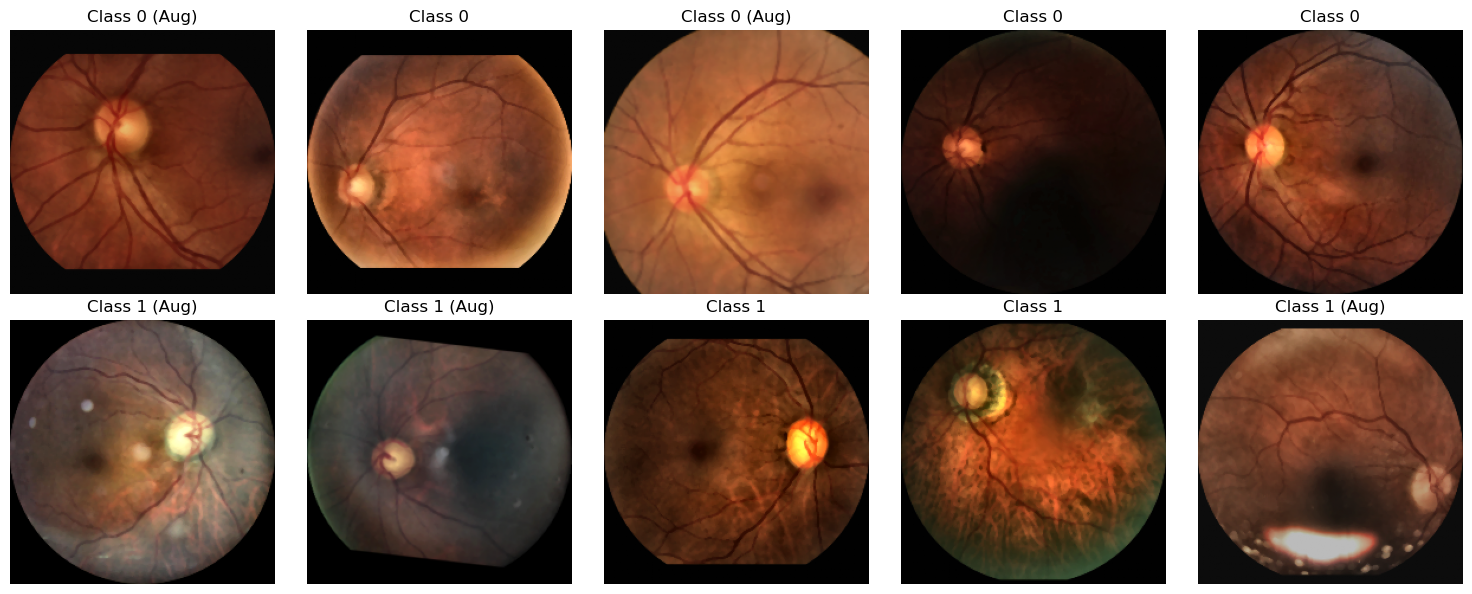

Creating train numpy arrays...


train_1: 100%|██████████| 13312/13312 [02:05<00:00, 106.42it/s]


  Saved 23898 images for train split
Creating val numpy arrays...


val_1: 100%|██████████| 2208/2208 [00:08<00:00, 252.56it/s]


  Saved 5747 images for val split
Creating test numpy arrays...


test_1: 100%|██████████| 1120/1120 [00:05<00:00, 219.10it/s]


  Saved 2874 images for test split
Numpy datasets created successfully
Preprocessing pipeline completed!
Dataset information: {'train_shape': (23898, 224, 224, 3), 'val_shape': (5747, 224, 224, 3), 'test_shape': (2874, 224, 224, 3), 'class_counts': {'train': {0: 10586, 1: 13312}, 'val': {0: 3539, 1: 2208}, 'test': {0: 1754, 1: 1120}}, 'preprocessing_mode': 'advanced'}


In [18]:
if __name__ == "__main__":
    output_dir = "../preprocessed_glaucoma_data"
    
    # Create preprocessor
    preprocessor = GlaucomaPreprocessor(
        input_dir=dataset_path,
        output_dir=output_dir,
        img_size=(224, 224)
    )

    # augmentation to handle imbalance in the dataset
    preprocessor.preprocess_dataset(apply_augmentation=True)
    
    # Visualize some samples
    preprocessor.visualize_preprocessed_samples(num_samples=5)
    
    # Create consolidated numpy arrays
    dataset_info = preprocessor.create_numpy_dataset()
    
    print("Preprocessing pipeline completed!")
    print(f"Dataset information: {dataset_info}")